Loading ChEMBL molecules from E:/summer2025/mol_struct/chembl_35_chemreps.txt
Cleaning and generating fingerprints for 700 molecules...


Processing molecules: 100%|██████████| 700/700 [00:02<00:00, 338.65it/s]


Saved cleaned set to random_chembl_subset.csv | Final shape: (500, 2050)
Epoch 1/20 | Train Loss: 0.2304 | Valid Loss: 0.1363
Epoch 2/20 | Train Loss: 0.0563 | Valid Loss: 0.0210
Epoch 3/20 | Train Loss: 0.0218 | Valid Loss: 0.0209
Epoch 4/20 | Train Loss: 0.0217 | Valid Loss: 0.0208
Epoch 5/20 | Train Loss: 0.0216 | Valid Loss: 0.0209
Epoch 6/20 | Train Loss: 0.0217 | Valid Loss: 0.0209
Epoch 7/20 | Train Loss: 0.0217 | Valid Loss: 0.0211
Epoch 8/20 | Train Loss: 0.0218 | Valid Loss: 0.0209
Epoch 9/20 | Train Loss: 0.0217 | Valid Loss: 0.0209
Epoch 10/20 | Train Loss: 0.0217 | Valid Loss: 0.0207
Epoch 11/20 | Train Loss: 0.0217 | Valid Loss: 0.0208
Epoch 12/20 | Train Loss: 0.0217 | Valid Loss: 0.0209
Epoch 13/20 | Train Loss: 0.0217 | Valid Loss: 0.0208
Epoch 14/20 | Train Loss: 0.0217 | Valid Loss: 0.0208
Epoch 15/20 | Train Loss: 0.0216 | Valid Loss: 0.0208
Epoch 16/20 | Train Loss: 0.0216 | Valid Loss: 0.0209
Epoch 17/20 | Train Loss: 0.0216 | Valid Loss: 0.0207
Epoch 18/20 | Trai

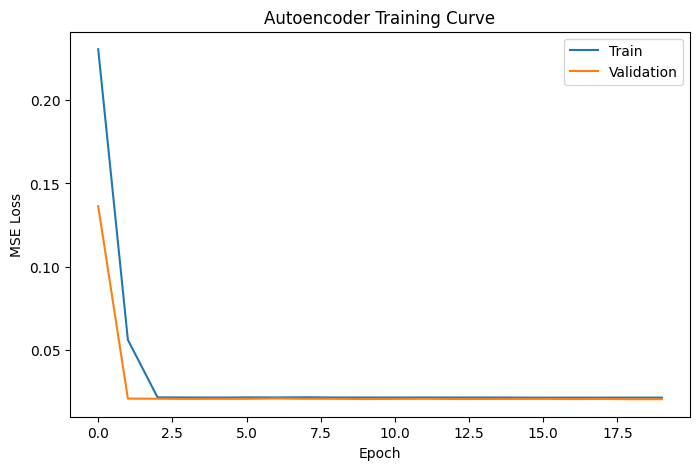

In [2]:
import random
import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
import matplotlib.pyplot as plt

# -------------------------
# 1. Data Extraction + Fingerprint Conversion
# -------------------------
def extract_random_chembl_molecules(
    txt_filepath,
    num_molecules_to_save=500,
    int_sample_size=700,
    fingerprint_bits=2048,
    output_csv_path='random_chembl_subset.csv',
    random_seed=42
):
    print(f"Loading ChEMBL molecules from {txt_filepath}")
    try:
        df_raw = pd.read_csv(txt_filepath, sep='\t', usecols=['chembl_id', 'canonical_smiles'])
        df_raw = df_raw.rename(columns={'canonical_smiles': 'SMILES', 'chembl_id': 'ID'})
    except Exception as e:
        print("Error reading file:", e)
        return pd.DataFrame()

    df_raw.dropna(subset=['SMILES'], inplace=True)

    if len(df_raw) < int_sample_size:
        int_sample_size = len(df_raw)

    df_sample = df_raw.sample(n=int_sample_size, random_state=random_seed).reset_index(drop=True)

    print(f"Cleaning and generating fingerprints for {int_sample_size} molecules...")
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=fingerprint_bits)
    cleaned_data = []
    unique_smiles = set()

    for _, row in tqdm.tqdm(df_sample.iterrows(), total=len(df_sample), desc="Processing molecules"):
        smiles = row['SMILES']
        mol_id = row['ID']
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue
        try:
            Chem.SanitizeMol(mol)
            cleaned_smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
            if cleaned_smiles in unique_smiles:
                continue
            unique_smiles.add(cleaned_smiles)

            fp = mfpgen.GetFingerprint(mol)
            arr = np.zeros((fingerprint_bits,), dtype=np.int8)
            DataStructs.ConvertToNumpyArray(fp, arr)

            mol_data = {'ID': mol_id, 'SMILES': cleaned_smiles}
            for i in range(fingerprint_bits):
                mol_data[f'bit_{i}'] = int(arr[i])

            cleaned_data.append(mol_data)
        except:
            continue

    df_cleaned = pd.DataFrame(cleaned_data)

    if len(df_cleaned) < num_molecules_to_save:
        print(f"Only {len(df_cleaned)} valid molecules available, using all.")
        df_final = df_cleaned
    else:
        df_final = df_cleaned.sample(n=num_molecules_to_save, random_state=random_seed).reset_index(drop=True)

    df_final.to_csv(output_csv_path, index=False)
    print(f"Saved cleaned set to {output_csv_path} | Final shape: {df_final.shape}")
    return df_final

# -------------------------
# 2. Split into Dataloaders
# -------------------------
def create_dataloaders(df, batch_size=64):
    df = df.drop(columns=['ID', 'SMILES'])
    X = torch.tensor(df.values, dtype=torch.float32)

    # Split
    N = len(X)
    train_end = int(0.8 * N)
    valid_end = int(0.9 * N)

    train_loader = DataLoader(TensorDataset(X[:train_end]), batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(TensorDataset(X[train_end:valid_end]), batch_size=batch_size)
    test_loader  = DataLoader(TensorDataset(X[valid_end:]), batch_size=batch_size)

    return train_loader, valid_loader, test_loader

# -------------------------
# 3. Autoencoder
# -------------------------
class Autoencoder(nn.Module):
    def __init__(self, input_dim=2048, hidden_dim=512, bottleneck_dim=128):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, bottleneck_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Use sigmoid since inputs are binary
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# -------------------------
# 4. Training Loop
# -------------------------
def train_autoencoder(model, train_loader, valid_loader, num_epochs=20, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, valid_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for (data,) in train_loader:
            output = model(data)
            loss = criterion(output, data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * data.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        total_valid_loss = 0
        with torch.no_grad():
            for (data,) in valid_loader:
                output = model(data)
                loss = criterion(output, data)
                total_valid_loss += loss.item() * data.size(0)
        avg_valid_loss = total_valid_loss / len(valid_loader.dataset)

        train_losses.append(avg_train_loss)
        valid_losses.append(avg_valid_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_valid_loss:.4f}")

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train")
    plt.plot(valid_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Autoencoder Training Curve")
    plt.legend()
    plt.show()

# -------------------------
# 5. Run the Full Pipeline
# -------------------------
txt_path = 'E:/summer2025/mol_struct/chembl_35_chemreps.txt'
df = extract_random_chembl_molecules(txt_path, num_molecules_to_save=500, fingerprint_bits=2048)

train_loader, valid_loader, test_loader = create_dataloaders(df)

input_dim = df.shape[1] - 2  # Exclude 'ID' and 'SMILES'
model = Autoencoder(input_dim=input_dim)
train_autoencoder(model, train_loader, valid_loader, num_epochs=20)

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def compute_latent_representations(model, data_loader, device='cpu'):
    model.eval()
    latent_vectors = []
    with torch.no_grad():
        for (batch,) in data_loader:
            batch = batch.to(device)
            z = model.encoder(batch)  # Get latent representation
            latent_vectors.append(z.cpu().numpy())
    latent_matrix = np.vstack(latent_vectors)  # Use NumPy, not torch.cat

    return latent_matrix  # Shape: (num_samples, bottleneck_dim)


def find_similar_molecules(query_idx, latent_matrix, df, top_k=5, metric='cosine'):
    query_vec = latent_matrix[query_idx].reshape(1, -1)
    
    if metric == 'cosine':
        sims = cosine_similarity(query_vec, latent_matrix)[0]
    else:  # Euclidean
        sims = -np.linalg.norm(latent_matrix - query_vec, axis=1)

    top_indices = np.argsort(sims)[::-1][:top_k+1]  # +1 to include query itself
    print(f"\nQuery Molecule: {df.iloc[query_idx]['SMILES']}")
    print("\nTop Similar Molecules:")
    for idx in top_indices:
        if idx == query_idx:  # Skip the query itself
            continue
        print(f"SMILES: {df.iloc[idx]['SMILES']} | Similarity: {sims[idx]:.4f}")


In [12]:
device = 'cpu'
model = model.to(device)

# Compute latent vectors for ALL molecules (train + valid + test)
full_df = df.drop(columns=['ID'])  # keep SMILES for reference
data_tensor = torch.tensor(full_df.iloc[:, 1:].values, dtype=torch.float32)  # drop ID
full_loader = DataLoader(TensorDataset(data_tensor), batch_size=64, shuffle=False)

latent_matrix = compute_latent_representations(model, full_loader, device)

# Find top-5 similar molecules for molecule at index 10
find_similar_molecules(query_idx=10, latent_matrix=latent_matrix, df=df, top_k=5)


Query Molecule: COc1cc2c(cc1OC)C(=O)C(Oc1ccc(C(=O)CN3CCCCC3)cc1)C2

Top Similar Molecules:
SMILES: COc1ccc(N2CCN(C(=O)CNC(=O)CCCN3CCc4cccc5c4C3CNC5=O)CC2)cc1 | Similarity: 0.9999
SMILES: COc1ccc(-c2ccc([C@H]3[C@@H](C#N)N(C(=O)NC4CCCC4)[C@@H]3CO)cc2)cc1 | Similarity: 0.9999
SMILES: CCC1(O)C[C@H]2CN(CCCc3c([nH]c4ccccc34)[C@@](C(=O)OC)(c3cc4c(cc3OC)N(C)C3[C@](O)(C(=O)OC)[C@H](OC(C)=O)[C@]5(CC)C=CCN6CC[C@]43[C@H]65)C2)C1 | Similarity: 0.9999
SMILES: COC(=O)c1cccc(-n2cc(CO[C@H]3[C@@H](O)[C@@H](CO)O[C@@H](OC)[C@@H]3O)nn2)c1 | Similarity: 0.9999
SMILES: COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\CCCCN(C)C(=O)N4C3)nc(-c3cccc(C)n3)nc2c1C | Similarity: 0.9998
